## Predicting the spread of COVID-19 in Singapore using the SEIRD Model

###### This model attempts to predict the spread of covid-19 in Singapore to identify the "risk - off" and "risk - on" dates. "Risk - off" dates suggest that portfolio managers would be investing/trading under a climate where there is an exponentially increasing number of COVID-19 cases. "Risk - on" dates suggests that portfolio managers would be investing/trading under a climate where the number of COVID-19 cases in Singapore have peaked and is also expected to decrease over time. The model also provides insights into the possible end-dates of COVID-19 in Singapore.    

### Import relevant Modules

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Plotting Code 

In [2]:
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'k', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')

  f, axS = plt.subplots(1,1,figsize=(10,4))
  axS.plot(t, S, 'b', alpha=0.7, linewidth=2)
  axS.title.set_text('Predicted Number of Susceptibles in Singapore')
  axS.set_xlabel('Time (days)')
  f, axE = plt.subplots(1,1,figsize=(10,4))
  axE.plot(t, E, 'y', alpha=0.7, linewidth=2)
  axE.title.set_text('Predicted Number of Exposed in Singapore')
  axE.set_xlabel('Time (days)')
  f, axI = plt.subplots(1,1,figsize=(10,4))
  axI.plot(t, I, 'k', alpha=0.7, linewidth=2)
  axI.title.set_text('Predicted Number of Infected in Singapore')
  axI.set_xlabel('Time (days)')
  f, axR = plt.subplots(1,1,figsize=(10,4))
  axR.plot(t, R, 'g', alpha=0.7, linewidth=2)
  axR.title.set_text('Predicted Number of Recovered in Singapore')
  axR.set_xlabel('Time (days)')
  if D is not None:
    ax.plot(t, D, 'r', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    f, axD = plt.subplots(1,1,figsize=(10,4))
    axD.plot(t, D, 'r', alpha=0.7, linewidth=2)
    axD.title.set_text('Predicted Number of Deaths in Singapore')
    axD.set_xlabel('Time (days)')

  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')

    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:

    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
   
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

### Calculate Derivatives for SIERD Model

In [3]:
def deriv(y, t, N, beta, gamma, delta, alpha_opt, rho):
    S, E, I, R, D = y
    def alpha(t):
        return s * I/N + alpha_opt

    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
    dRdt = (1 - alpha(t)) * gamma * I
    dDdt = alpha(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

### Model Parameters


In [4]:
N = 5_600_000 #Estimated population number for the country being modelled 
D = 14.0 # infections lasts fourteen days
gamma = 1.0 / D
delta = 1.0 / 7.0  # incubation period of seven days

R_0_start, k, x0, R_0_end = 7.25, 0.85, 38, 0.5 # No. of other infections per infected person (pre-lockdown), 
#                                               impact of lockdown on spread of disease, day of lockdown,
#                                               No. of other infections per infected person (post-lockdown)

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end 

def beta(t):
    return logistic_R_0(t) * gamma

alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3} # Vulnerability to disease by agegroup
proportion_of_agegroup = {"0-29": 0.34, "30-59": 0.5, "60-89": 0.1, "89+": 0.07} #Population Demographics
s = 0.1 
alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

rho = 1/35  # 35 days from infection until death
S0, E0, I0, R0, D0 = N-1, 4, 0, 0, 0  # initial conditions: four exposed

In [5]:
t = np.linspace(0, 500, 500) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha_opt, rho))
S, E, I, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time

### Model Results

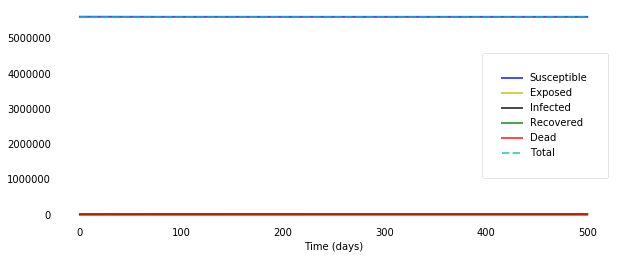

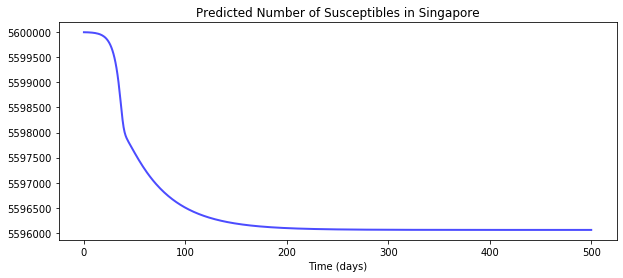

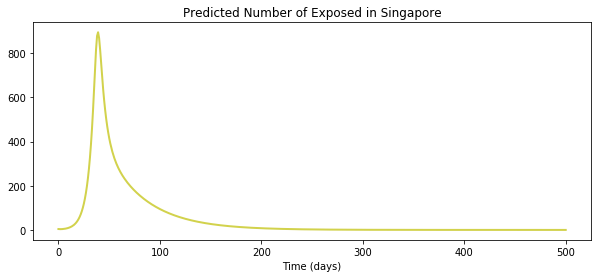

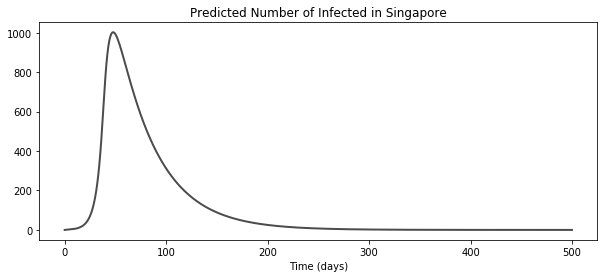

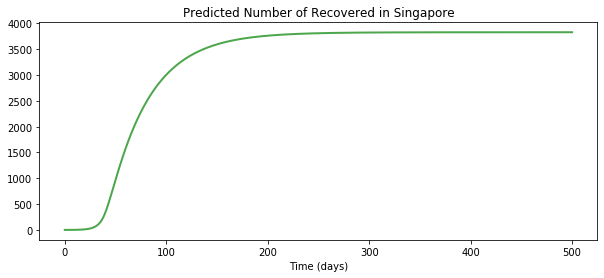

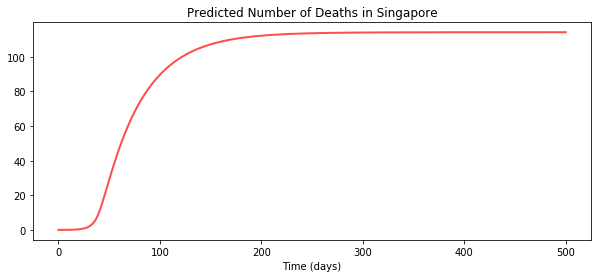

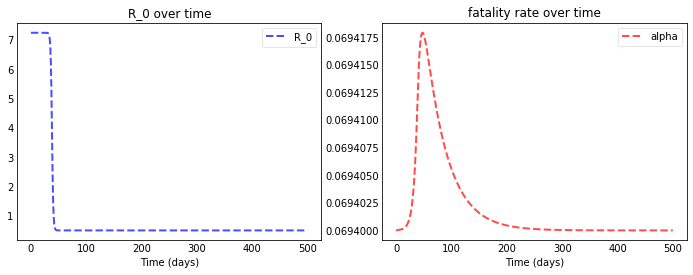

In [6]:
plotseird(t, S, E, I, R, D, R0=R0_over_time, Alpha=Alpha_over_time)

In [7]:
I = pd.DataFrame(I)
ipoint = int(I.idxmax())

print('Forecasted inflection point : {} days from day 0 '.format(ipoint))
print('Risk off dates : day 0 to day {} '.format(ipoint))
print('Risk on dates : after day {}'.format(ipoint))

Forecasted inflection point : 48 days from day 0 
Risk off dates : day 0 to day 48 
Risk on dates : after day 48
